In [ ]:
%load_ext nb_black

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import mean_squared_error as mse
from dies.utils_pytorch import np_to_dev, dev_to_np
from dies.adaboost import AdaBoost, ELM


sns.set_context("poster")
sns.set_style("whitegrid")
mpl.rcParams["legend.loc"] = "upper left"

/home/scribbler/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Create the dataset
def get_data(n=100):
    X = np.linspace(-6, 6, n)[:, np.newaxis]
    y = np.sin(X).ravel() + np.sin(6 * X).ravel() + np.random.normal(0, 0.2, X.shape[0])

    return np_to_dev(((X))), np_to_dev(((y.reshape(-1, 1))))


def get_data_2d(n=1000):
    X = np.linspace(-6, 6, n)[:, np.newaxis]

    ys = np.ones((n, 2))
    y1 = (
        np.sin(X).ravel() + np.sin(6 * X).ravel() + np.random.normal(0, 0.1, X.shape[0])
    )
    y2 = (
        np.cos(X).ravel() + np.cos(6 * X).ravel() + np.random.normal(0, 0.3, X.shape[0])
    )

    ys[:, 0] = y1
    ys[:, 1] = y2 + 2

    return np_to_dev(((X))), np_to_dev(ys)

# ELM

Internally, adaboost uses an extreme learning machine. So lets see if it works.

In [3]:
# create trainings data
X, y = get_data()
# fit the model
model = ELM([1, 1000, 1]).fit(X, y)
# create test data
X, y = get_data()
yh = model.predict(X)

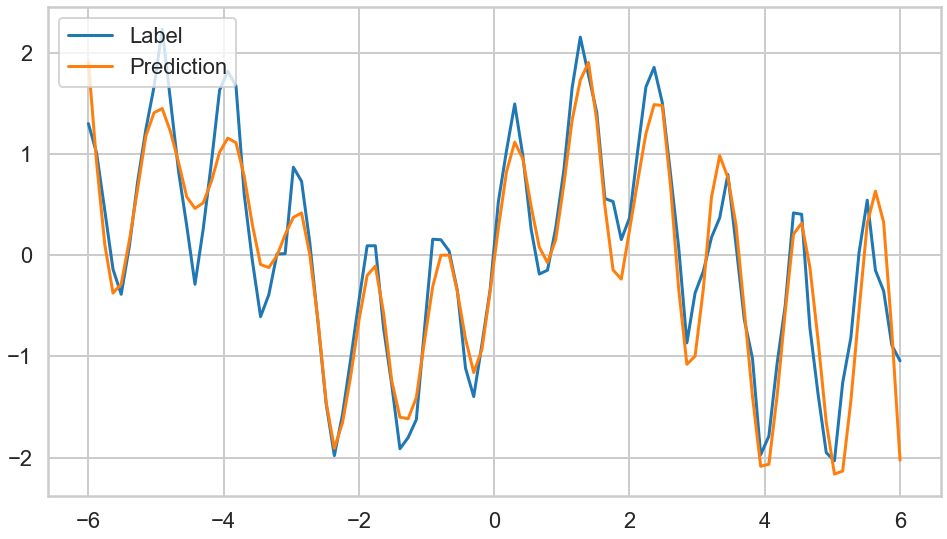

In [4]:
plt.figure(figsize=(16, 9))
plt.plot(dev_to_np(X), dev_to_np(y), label="Label")
plt.plot(dev_to_np(X), yh, label="Prediction")
plt.legend()

In [5]:
error = mse(dev_to_np(y), yh, squared=False)
print(f"RMSE {error:0.3f}")

RMSE 0.356


# Single Estimator

In [6]:
# create trainings data
X, y = get_data()
# fit the model
model = AdaBoost(n_estimators=1, n_hidden=1000).fit(X, y)

In [7]:
# create test data
X, y = get_data()
yh = model.predict(X)

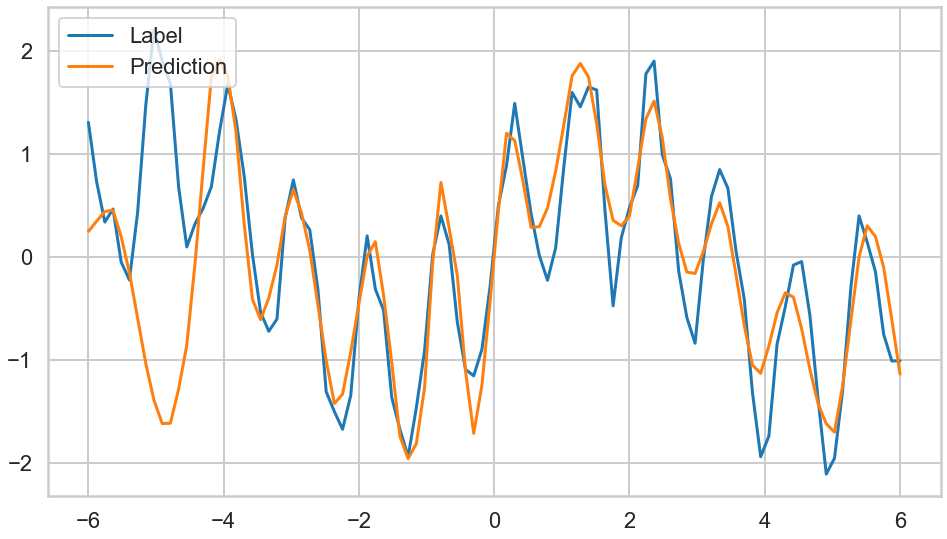

In [8]:
plt.figure(figsize=(16, 9))
plt.plot(dev_to_np(X), dev_to_np(y), label="Label")
plt.plot(dev_to_np(X), yh, label="Prediction")
plt.legend()

In [9]:
error = mse(dev_to_np(y), yh, squared=False)
print(f"RMSE {error:0.3f}")

RMSE 0.791


# Mutiple Estimators

In [10]:
# create trainings data
X, y = get_data()
# fit the model
model = AdaBoost(n_estimators=10, n_hidden=100).fit(X, y)

In [11]:
# create test data
X, y = get_data()
yh = model.predict(X)

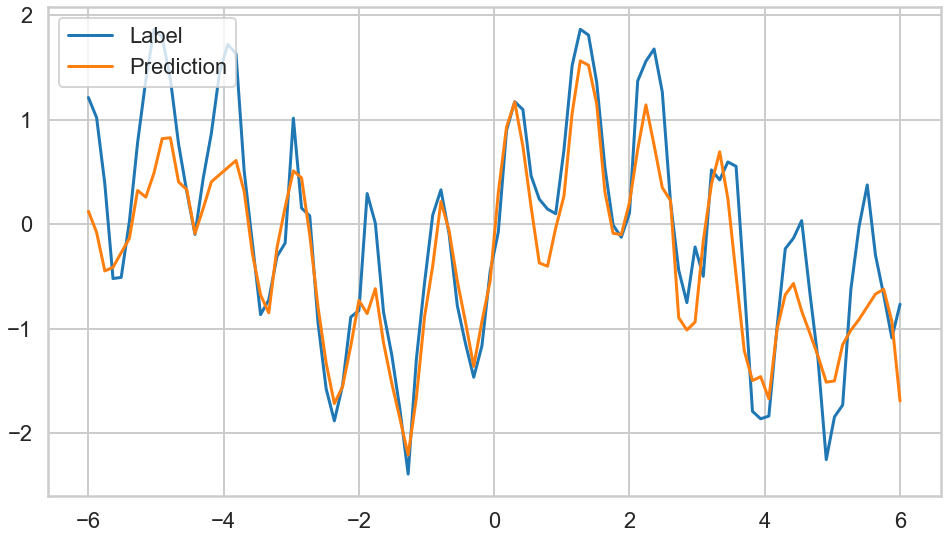

In [12]:
plt.figure(figsize=(16, 9))
plt.plot(dev_to_np(X), dev_to_np(y), label="Label")
plt.plot(dev_to_np(X), yh, label="Prediction")
plt.legend()

In [13]:
error = mse(dev_to_np(y), yh, squared=False)
print(f"RMSE {error:0.3f}")

RMSE 0.524


Note, that with rougly the same amount of weights, compared to the single estimator/ELM, we receive **improvement** of the RMSE.
[1 estimator with 1000 hidden neurons vs. 10 estimators with 100 neurons]

# Multi-Task Forecast

In [14]:
# create trainings data
X, y = get_data_2d()
# fit the model
model1 = AdaBoost(n_estimators=10, n_hidden=100, weight_tasks_error=False, lr=1e-4).fit(
    X, y
)
model2 = AdaBoost(n_estimators=10, n_hidden=100, weight_tasks_error=True, lr=1e-4).fit(
    X, y
)

In [15]:
# create test data
X, y = get_data_2d()
yh1 = model1.predict(X)
yh2 = model2.predict(X)

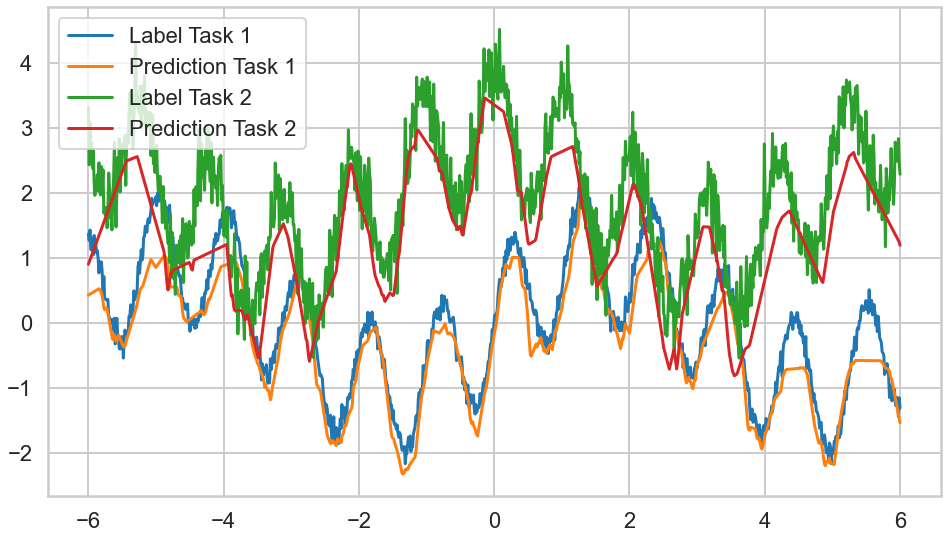

In [16]:
plt.figure(figsize=(16, 9))
plt.plot(dev_to_np(X), dev_to_np(y)[:, 0], label="Label Task 1")
plt.plot(dev_to_np(X), yh1[:, 0], label="Prediction Task 1")

plt.plot(dev_to_np(X), dev_to_np(y)[:, 1], label="Label Task 2")
plt.plot(dev_to_np(X), yh1[:, 1], label="Prediction Task 2")
plt.legend()
plt.show()

## No task related weighting results:

In [17]:
error = mse(dev_to_np(y[:, 0]), yh1[:, 0], squared=False)
print(f"RMSE Task 1 {error:0.3f}")
error = mse(dev_to_np(y[:, 1]), yh1[:, 1], squared=False)
print(f"RMSE Task 2 {error:0.3f}")

RMSE Task 1 0.386
RMSE Task 2 0.718


## Task related weighting results:

In [18]:
error = mse(dev_to_np(y[:, 0]), yh2[:, 0], squared=False)
print(f"RMSE Task 1 {error:0.3f}")
error = mse(dev_to_np(y[:, 1]), yh2[:, 1], squared=False)
print(f"RMSE Task 2 {error:0.3f}")

RMSE Task 1 0.388
RMSE Task 2 0.945


Does not seem to work reliably, maybe needs some more refined weighting scheme. But lets test in detail:

In [19]:
error1, error2 = [], []
for i in range(100):
    # create trainings data
    X, y = get_data_2d()
    # fit the model
    model1 = AdaBoost(
        n_estimators=10, n_hidden=100, weight_tasks_error=False, lr=1e-4
    ).fit(X, y)
    model2 = AdaBoost(
        n_estimators=10, n_hidden=100, weight_tasks_error=True, lr=1e-4
    ).fit(X, y)
    # create test data
    X, y = get_data_2d()
    yh1 = model1.predict(X)
    yh2 = model2.predict(X)
    e1 = mse(dev_to_np(y), yh1, squared=False)
    e2 = mse(dev_to_np(y), yh2, squared=False)
    error1.append(e1)
    error2.append(e2)

This should bre retrained, but not yet implemented.


/home/scribbler/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/scribbler/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


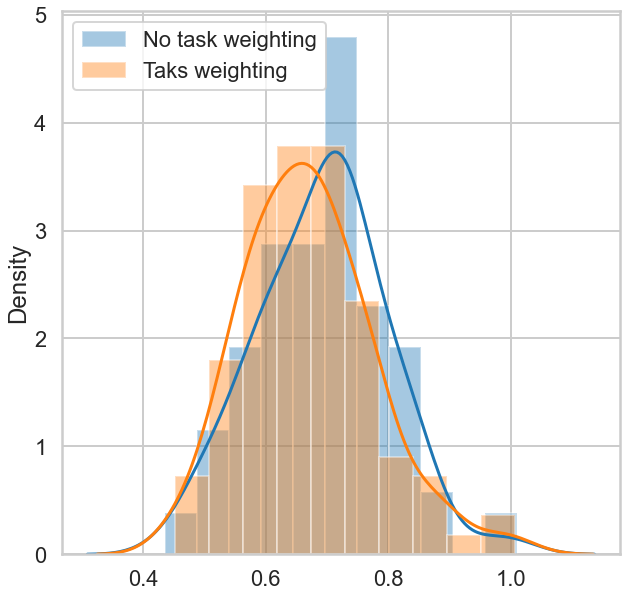

In [20]:
plt.figure(figsize=(10, 10))
sns.distplot(error1, label="No task weighting")
sns.distplot(error2, label="Taks weighting")
plt.legend()

Maybe it works a little bit :)

## Compare too a model on each task.

In [21]:
# create trainings data
X, y = get_data_2d()
# fit the model
model1 = AdaBoost(n_estimators=10, n_hidden=100).fit(X, y[:, 0].reshape(-1, 1))
model2 = AdaBoost(n_estimators=10, n_hidden=100).fit(X, y[:, 1].reshape(-1, 1))

In [22]:
# create test data
X, y = get_data_2d()
yh1 = model1.predict(X)
yh2 = model2.predict(X)

In [23]:
error = mse(dev_to_np(y[:, 0]), yh1, squared=False)
print(f"RMSE Task 1 {error:0.3f}")

RMSE Task 1 0.401


In [24]:
error = mse(dev_to_np(y[:, 1]), yh2, squared=False)
print(f"RMSE Task 2 {error:0.3f}")

RMSE Task 2 0.627


The results of an MTL approach and an STL approach are about similar.